# Ensembles

В этом проекте мы построим ансамбль из пяти базовых моделей с помощью методов Blending и Stacking и сравним результаты

### Ключевые этапы
- Предобработка данных
- Выбор базовых моделей для создания ансамбля
- Обучение базовых моделей и оценка качества каждой из них
- Blending: берем разные подвыборки для каждой базовой модели и смотрим, какой результат они дают вместе; взвешиваем ответы моделей с помощью метамодели
- Stacking: подбираем лучшую метамодель и находим оптимальные параметры
- Оценка эффективности моделей и сравнение результатов

## 1 Подготовка данных

Загрузим и совершим предобработку данных из Project_1_data_handling

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train_features_with_answers.csv to train_features_with_answers.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('train_features_with_answers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      454 non-null    object 
 1   sex         454 non-null    object 
 2   age         426 non-null    float64
 3   address     449 non-null    object 
 4   famsize     454 non-null    object 
 5   Pstatus     454 non-null    object 
 6   Medu        454 non-null    int64  
 7   Fedu        454 non-null    int64  
 8   Mjob        454 non-null    object 
 9   Fjob        454 non-null    object 
 10  reason      454 non-null    object 
 11  guardian    454 non-null    object 
 12  traveltime  454 non-null    int64  
 13  studytime   454 non-null    int64  
 14  failures    454 non-null    int64  
 15  schoolsup   454 non-null    object 
 16  famsup      454 non-null    object 
 17  paid        454 non-null    object 
 18  activities  454 non-null    object 
 19  nursery     454 non-null    o

In [4]:
df['sex'] = df['sex'].where(df['sex'].isin(["F", "M"]), np.nan)

df['age'] = df['age'].where(
    ~df['age'].isna() & (df['age'] >= 15) & (df['age'] <= 22),
    np.nan
)

value_counts_dict = {col: df[col].value_counts(dropna=False) for col in df.columns}
print(value_counts_dict)

{'school': school
GP    288
MS    166
Name: count, dtype: int64, 'sex': sex
F      257
M      189
NaN      8
Name: count, dtype: int64, 'age': age
17.0    111
16.0    111
18.0     95
15.0     73
NaN      36
19.0     19
20.0      6
21.0      2
22.0      1
Name: count, dtype: int64, 'address': address
U      306
R      143
NaN      5
Name: count, dtype: int64, 'famsize': famsize
GT3    325
LE3    129
Name: count, dtype: int64, 'Pstatus': Pstatus
T    403
A     51
Name: count, dtype: int64, 'Medu': Medu
2    128
4    116
1    106
3    102
0      2
Name: count, dtype: int64, 'Fedu': Fedu
2    150
1    116
3    101
4     81
0      6
Name: count, dtype: int64, 'Mjob': Mjob
other       188
at_home      99
services     94
teacher      42
health       31
Name: count, dtype: int64, 'Fjob': Fjob
other       268
services    127
at_home      31
teacher      16
health       12
Name: count, dtype: int64, 'reason': reason
course        209
home          104
reputation     97
other          44
Name: co

In [5]:
df = df.drop(columns=['Fedu', 'Dalc'])
df

,school,sex,age,address,famsize,Pstatus,Medu,Mjob,Fjob,reason,...,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,G3
0,MS,M,NaN,U,LE3,T,1,at_home,services,course,...,no,yes,yes,4,3,3,3,3,0,9
1,GP,M,NaN,R,LE3,T,3,teacher,other,home,...,yes,yes,no,3,3,4,5,3,16,12
2,GP,M,15.0,NaN,GT3,T,3,other,other,home,...,yes,yes,no,5,5,1,1,5,0,13
3,MS,M,17.0,R,GT3,T,4,services,other,home,...,yes,yes,yes,4,5,5,3,2,4,11
4,GP,F,20.0,R,GT3,T,2,other,other,course,...,no,yes,yes,1,2,3,2,2,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,GP,M,15.0,U,GT3,T,4,other,other,course,...,yes,yes,no,3,3,3,1,3,0,10
450,GP,F,15.0,U,GT3,T,2,other,other,course,...,yes,yes,no,5,1,2,1,3,4,10
451,GP,M,16.0,U,GT3,T,4,services,services,course,...,yes,yes,no,5,3,2,2,5,4,15
452,MS,F,15.0,R,LE3,T,1,at_home,services,reputation,...,yes,yes,no,5,4,3,2,4,0,10


In [6]:
# 'sex'  'age' 'address' with None
# ищу похожие строки с помощью евклидова расстояния(только числовые признаки)
def similarity(row1, row2, numeric_columns):
        diff = row1[numeric_columns] - row2[numeric_columns]
        return np.sqrt((diff**2).sum())
# беру самую похожую строку и беру значение оттуда
def fill_nan(df, column):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    if column in numeric_columns:
        numeric_columns.remove(column)

    df_copy = df.copy()
    nan_indices = df[df[column].isna()].index

    for idx in nan_indices:
        current_row = df_copy.loc[idx]
        candidates = df_copy.drop(idx).dropna(subset=[column])

        similarities = candidates.apply(lambda row: similarity(current_row, row, numeric_columns), axis=1)

        closest_match_idx = similarities.idxmin()

        df_copy.at[idx, column] = df_copy.at[closest_match_idx, column]

    return df_copy

df = fill_nan(df, 'sex')
df  = fill_nan(df, 'age')
df = fill_nan(df, 'address')

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
encoder = OneHotEncoder(sparse_output=False)

categorical = ["school", "sex", "address", "famsize", "Pstatus",
               "Mjob", "Fjob", "reason","guardian",
               "schoolsup", "famsup", "paid", "activities",
               "nursery", "higher", "internet", "romantic"]

encoded_array = encoder.fit_transform(df[categorical])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical))
df = pd.concat([df.drop(categorical, axis=1), encoded_df], axis=1)
df

,age,Medu,traveltime,studytime,failures,famrel,freetime,goout,Walc,health,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18.0,1,1,1,0,4,3,3,3,3,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,17.0,3,3,1,0,3,3,4,5,3,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15.0,3,1,2,0,5,5,1,1,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,17.0,4,2,2,1,4,5,5,3,2,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,20.0,2,2,2,0,1,2,3,2,2,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,15.0,4,1,4,0,3,3,3,1,3,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
450,15.0,2,1,4,0,5,1,2,1,3,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
451,16.0,4,1,1,0,5,3,2,2,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
452,15.0,1,2,2,0,5,4,3,2,4,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df.drop(columns=['G3']))
df_scaler = pd.DataFrame(df_scaler, columns=df.drop(columns=['G3']).columns)
df = pd.concat([df_scaler, df['G3']], axis=1)
df

,age,Medu,traveltime,studytime,failures,famrel,freetime,goout,Walc,health,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,G3
0,0.981324,-1.333406,-0.772553,-1.097453,-0.383276,0.095112,-0.169875,-0.188474,0.530324,-0.375232,...,-0.956876,-0.510990,0.510990,2.842534,-2.842534,-0.585829,0.585829,-1.323448,1.323448,9
1,0.182899,0.452335,1.806410,-1.097453,-0.383276,-0.958082,-0.169875,0.658728,2.054166,-0.375232,...,1.045067,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,12
2,-1.413951,0.452335,-0.772553,0.135823,-0.383276,1.148306,1.688515,-1.882879,-0.993518,1.009771,...,1.045067,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,13
3,0.182899,1.345206,0.516929,0.135823,1.289872,0.095112,1.688515,1.505930,0.530324,-1.067733,...,1.045067,1.956984,-1.956984,-0.351799,0.351799,-0.585829,0.585829,-1.323448,1.323448,11
4,2.578175,-0.440535,0.516929,0.135823,-0.383276,-3.064470,-1.099070,-0.188474,-0.231597,-1.067733,...,1.045067,-0.510990,0.510990,2.842534,-2.842534,-0.585829,0.585829,-1.323448,1.323448,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,-1.413951,1.345206,-0.772553,2.602377,-0.383276,-0.958082,-0.169875,-0.188474,-0.993518,-0.375232,...,-0.956876,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,10
450,-1.413951,-0.440535,-0.772553,2.602377,-0.383276,1.148306,-2.028265,-1.035677,-0.993518,-0.375232,...,-0.956876,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,10
451,-0.615526,1.345206,-0.772553,-1.097453,-0.383276,1.148306,-0.169875,-1.035677,-0.231597,1.009771,...,1.045067,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,15
452,-1.413951,-1.333406,0.516929,0.135823,-0.383276,1.148306,0.759320,-0.188474,-0.231597,0.317269,...,-0.956876,-0.510990,0.510990,-0.351799,0.351799,-0.585829,0.585829,0.755602,-0.755602,10


In [11]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [12]:
X = df.drop(columns=['G3'])
y = df['G3']

smote = SMOTE(sampling_strategy={0: 20, 7: 20, 18: 20}, random_state=42, k_neighbors=5)
ros = RandomOverSampler(sampling_strategy={1: 10, 5: 10, 6: 10, 19: 10}, random_state=42) #их слишком мало для SMOTE


X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

print("After Oversampling:", dict(zip(*np.unique(y_resampled, return_counts=True))))

After Oversampling: {0: 20, 1: 10, 5: 10, 6: 10, 7: 20, 8: 26, 9: 26, 10: 70, 11: 69, 12: 47, 13: 60, 14: 47, 15: 36, 16: 23, 17: 21, 18: 20, 19: 10}


In [13]:
#df.info()

## 2 Обоснование выбора слабых (базовых) алгоритмов

Попробуем использовать простые модели из Project_1_data_handling. Все они разные(что важно), но одни сильно коррелируют между собой, а некоторые не так сильно. Посмотрим, как ситуацию улучшат Стекинг и Блендинг. Интересно сравнить со взвешиванием, которое делали в Project_1_data_handling.
 Сначала посмотрим, как они работают по отдельности, а потом посмотрим как улучшит качество Blending и Stacking

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
preds = model_1.predict(X_test).astype(np.int64)

print("LogisticRegression MSE test:", mean_squared_error(y_test, preds))
print("LogisticRegression MSE train", mean_squared_error(y_train, model_1.predict(X_train)))

LogisticRegression MSE test: 8.82857142857143
LogisticRegression MSE train 8.722808688918608


In [17]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
preds = model_1.predict(X_test).astype(np.int64)

print("LogisticRegression MSE test:", mean_squared_error(y_test, preds))
print("LogisticRegression MSE train", mean_squared_error(y_train, model_1.predict(X_train)))

LogisticRegression MSE test: 8.82857142857143
LogisticRegression MSE train 8.722808688918608


In [18]:
model_3 = SVC()

model_3.fit(X_train, y_train)
preds = model_2.predict(X_test)

print("SVC MSE test:", mean_squared_error(y_test, preds))
print("SVC MSE train", mean_squared_error(y_train, model_2.predict(X_train)))

SVC MSE test: 8.323809523809524
SVC MSE train 5.1571428571428575


In [19]:
model_4 = KNeighborsClassifier()
model_4.fit(X_train, y_train)
preds = model_3.predict(X_test).astype(np.int64)

print("KNeighborsClassifier MSE test:", mean_squared_error(y_test, preds))
print("KNeighborsClassifier MSE train", mean_squared_error(y_train, model_3.predict(X_train)))

KNeighborsClassifier MSE test: 7.933333333333334
KNeighborsClassifier MSE train 3.2285714285714286


In [20]:
model_5 = GaussianNB()
model_5.fit(X_train, y_train)
preds = model_4.predict(X_test).astype(np.int64)

print("GaussianNB MSE test:", mean_squared_error(y_test, preds))
print("GaussianNB MSE train", mean_squared_error(y_train, model_4.predict(X_train)))

GaussianNB MSE test: 18.78095238095238
GaussianNB MSE train 15.683333333333334


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## 3 Краткая *теория* по применяемым алгоритмам построения ансамблей

Источник - https://habr.com/ru/articles/799483/

## Blending

Блендинг является более простой версией стекинга. Тренировочные данные разделяются на 2 части: также на тренировочную и валидационную с помощью hold-out кросс-валидации. Базовая модель обучается на тренировочных данных и делает прогноз как на валидационном, так и на тестовом наборе. Далее предыдущий шаг повторяется для каждой базовой модели: к прогнозам на валидационном наборе добавляется таргет y_val и полученный датасет используется в качестве тренировочного, а прогнозы на тестовом наборе используются в качестве нового тестового.

На полученных датасетах (метаданных) обучается метамодель и производится итоговый прогноз.

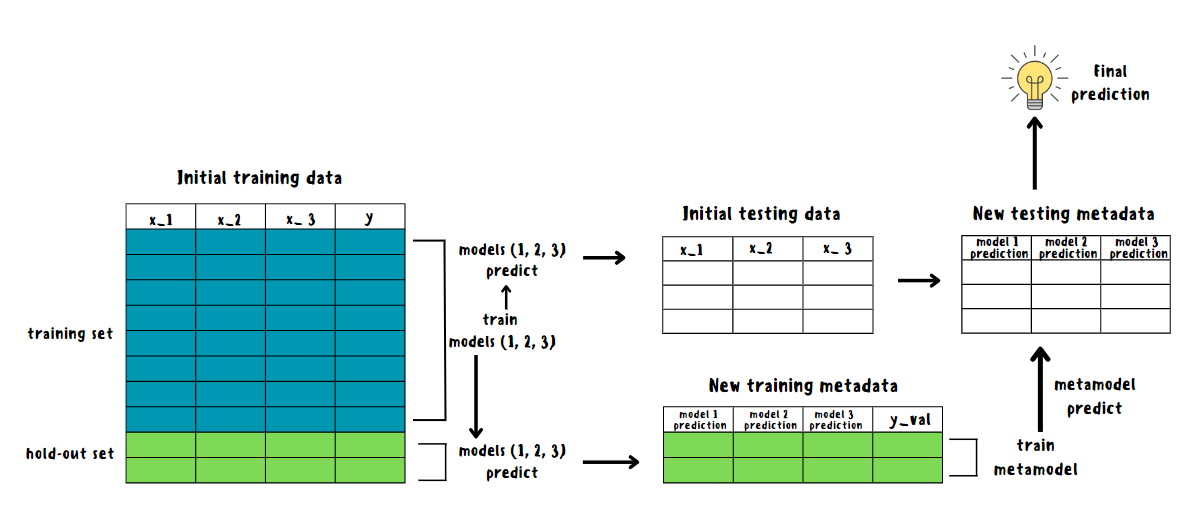

## Steking

Изначально датасет разбивается на тренировочный и тестовый. Далее с помощью k-fold кросс-валидации тренировочный датасет разбивается на k фолдов. Базовая модель обучается на k-1 фолдах и делает прогноз на оставшемся. Данная процедура повторяется для каждого фолда и в итоге получится вектор, состоящий из k-fold прогнозов и используемый как новый признак. Предыдущие шаги повторяются для каждой базовой модели и в итоге получится набор признаков, состоящий из прогнозов базовых моделей, к которым добавляется таргет y_train из исходного тренировочного датасета и полученный датасет будет новым тренировочным. Помимо этого, базовые модели также обучаются на всём исходном тренировочном множестве, после чего делается прогноз на тестовом датасете и в итоге получится новый тестовый набор.

На полученных датасетах (метаданных) обучается метамодель и производится итоговый прогноз.

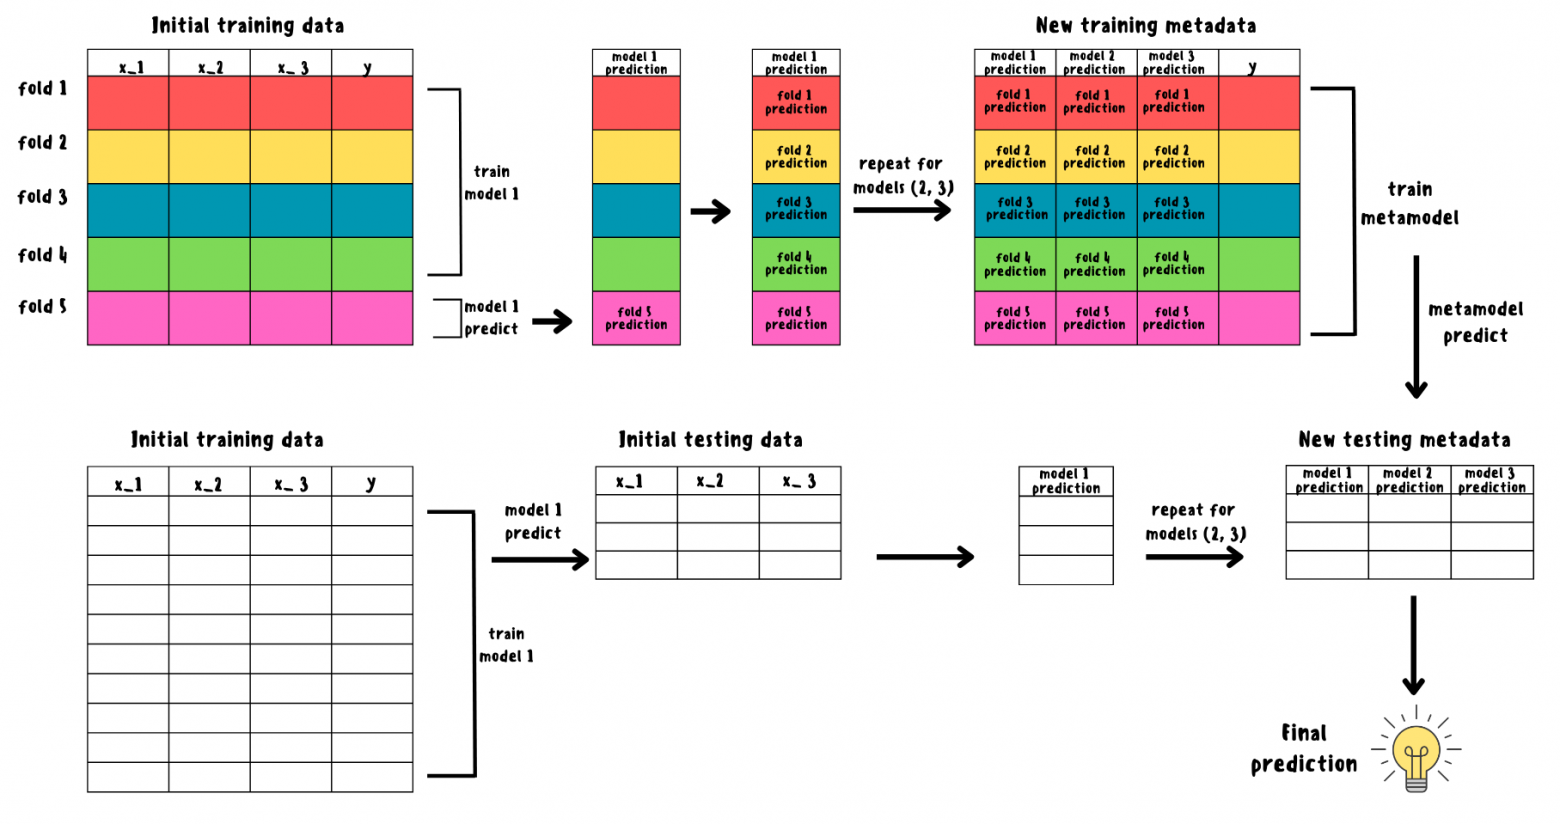

## 4 Построение решения на основе подхода Blending

Правила:
- Предложить что-то лучше, чем брать среднее от предсказаний моделей (оценивать уверенность алгоритмов, точности и т.д.)
- Заставить базовые алгоритмы быть некорелированными
- Добавить рандома (например, стройть алгоритмы на разных выборках, по разному предобрабатывайть данные или применяйть для разных признаков соответствующие алгоритмы ... )
- Цель: метрика MSE на тесте меньше 10

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
model_1 = LinearRegression()
model_2 = LogisticRegression()
model_3 = SVC()
model_4 = KNeighborsClassifier()
model_5 = GaussianNB()

models = [model_1, model_2, model_3, model_4, model_5]

In [24]:
from sklearn.utils import resample

In [25]:
num_bootstrap_samples = 5  # Количество бутстрап-выборок

bootstrap_samples = [
    resample(X_train_train, y_train_train, random_state=None) for i in range(num_bootstrap_samples)
]

In [26]:
preds_val = []

for i in range(len(models)):
  X_b = bootstrap_samples[i][0]
  y_b = bootstrap_samples[i][1]
  models[i].fit(X_b, y_b)
  preds_val.append(pd.Series(models[i].predict(X_val)))

# Создание метапризнаков для blending
meta_features = pd.concat(preds_val, axis=1)

# Метамодель
meta_model = LinearRegression()
meta_model.fit(meta_features, y_val)

preds_test = []

for model in models:
  preds_test.append(pd.Series(model.predict(X_test)))

#Создание новых тестовых данных
X_test_stacked = pd.concat(preds_test, axis=1)
# print(X_test)

# Оценка на тестовой выборке
blended_preds = meta_model.predict(X_test_stacked).astype(np.int64)
print("Blending MSE:", mean_squared_error(y_test, blended_preds))

Blending MSE: 4.6415094339622645


Вывод: Blending над пятью базовыми моделями показывает хороший результат. Качество на тестовой выборке лучше, чем для любой из пяти базовых моделей

Среднее MSE пяти моделей: 10.54

MSE с использованием Blending: 4.64

## 5 Постройте решение на основе подхода Stacking

Правила:
- Реализовать пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Провести оптимизацию пайплайна
- Оценить вклад каждого базового алгоритма в итоговое предсказание
- Цель: метрика MSE на тесте меньше 10

In [27]:
model_1 = LinearRegression()
model_2 = LogisticRegression()
model_3 = SVC()
model_4 = KNeighborsClassifier()
model_5 = GaussianNB()

models = [model_1, model_2, model_3, model_4, model_5]

meta_model = LinearRegression()

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
class StackingPipeline():
  def __init__(self, models=models, meta_model=meta_model):
    self.scaler = StandardScaler()
    self.models = models
    self.meta_model = meta_model
    self.meta_features = []
    self.X_test_meta = []

  def make_x_test_meta(self):
    test_preds = []
    for model in self.models:
      test_preds.append(pd.Series(model.predict(X_test)))

    X_test_satcked = pd.concat(test_preds, axis=1)
    self.X_test_meta = self.scaler.transform(X_test_satcked)

  def fit(self, X_train, y_train):
    preds_cv = []

    for model in self.models:
      preds_cv.append(pd.Series(cross_val_predict(model, X_train, y_train, cv=6).ravel()))
      model.fit(X_train, y_train)

    # Создание мета-признаков для stacking
    meta_features = pd.concat(preds_cv, axis=1)
    self.meta_features = self.scaler.fit_transform(meta_features)

    self.make_x_test_meta()

    # Обучение метамодели на мета-признаках
    self.meta_model.fit(self.meta_features, y_train)

  def predict(self, X_test):
    stacked_preds = self.meta_model.predict(self.X_test_meta)

    return stacked_preds


In [30]:
# model_1 = LogisticRegression(C=0.0001, l1_ratio=0, max_iter=1000, penalty=None,solver='saga')
model_1 = LogisticRegression()
model_2 = SVC()
model_3 = DecisionTreeClassifier()
model_4 = GaussianNB()
model_5 = LinearRegression()

meta_models = [model_1, model_2, model_3, model_4, model_5]

model_1 = LogisticRegression()
model_2 = SVC()
model_3 = KNeighborsClassifier()
model_4 = GaussianNB()
model_5 = LinearRegression()

models = [model_1, model_2, model_3, model_4, model_5]

LogisticRegression() MSE: 4.60377358490566

In [31]:
for meta_model in meta_models:
  pipe = StackingPipeline(models, meta_model)
  pipe.fit(X_train, y_train)
  y_preds = pipe.predict(X_test)

  print(f'{meta_model} MSE: {mean_squared_error(y_test, y_preds)}')

LogisticRegression() MSE: 4.60377358490566
SVC() MSE: 3.849056603773585
DecisionTreeClassifier() MSE: 9.547169811320755
GaussianNB() MSE: 7.849056603773585
LinearRegression() MSE: 3.61765913891866


Лучшее качество показала модель LinearRegression(): MSE = 3.61

Второе и третье место заняли модели SVC(MSE = 3.85) и LogisticRegression(MSE = 4.60)

Так как у LinearRegression интересных нам гиперпараметров особо нет, попробуем подобрать оптимальные параметры для второй и третей модели, и сравним качество

Начнем с LogisticRegression

In [32]:
from sklearn.model_selection import GridSearchCV

In [55]:
param_grid = [
    # L1 и L2-регуляризация (liblinear и saga поддерживают L1)
    {
        'penalty': ['l1', 'l2'],
        'C': list(np.logspace(-4, 4, 40)),
        'solver': ['liblinear', 'saga']
    },
    # Только L2-регуляризация (lbfgs, sag, newton-cg)
    {
        'penalty': ['l2'],
        'C': list(np.logspace(-4, 4, 40)),
        'solver': ['lbfgs', 'sag', 'newton-cg']
    },
    # ElasticNet (только solver='saga' поддерживает)
    {
        'penalty': ['elasticnet'],
        'C': list(np.logspace(-4, 4, 40)),
        'solver': ['saga'],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
    },
    # Без регуляризации (penalty=None)
    {
        'penalty': [None],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
    }
]

In [56]:
meta_model = LogisticRegression()

pipe = StackingPipeline(models, meta_model)
pipe.fit(X_train, y_train)

meta_features = pipe.meta_features
meta_features

array([[-1.17725149, -1.45905601, -0.78610025, -1.27544064, -1.23076436],
       [-0.95054292, -1.16221358, -0.59861196, -1.09621826, -0.9093412 ],
       [-0.72383435,  0.02515614, -0.59861196, -1.09621826, -0.96216998],
       ...,
       [-0.27041721, -0.27168629,  0.15134118,  0.3375608 , -0.77503202],
       [-0.49712578, -0.27168629,  0.90129432,  0.3375608 , -0.13634316],
       [ 1.54325134,  0.02515614,  1.46375918,  0.87522795,  0.73491744]])

In [57]:
clf = GridSearchCV(meta_model, param_grid = param_grid, cv = 5, verbose=1, n_jobs=-1)
clf

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.0001603718743751331,
                                0.00025719138090593444, 0.0004124626382901352,
                                0.0006614740641230146, 0.0010608183551394483,
                                0.0017012542798525892, 0.0027283333764867696,
                                0.004375479375074184, 0.007017038286703823,
                                0.011253355826007646, 0.018047217668271703,
                                0.028942661247167517, 0.0464...
                                0.49238826317067363, 0.7896522868499725,
                                1.2663801734674023, 2.030917620904735,
                                3.257020655659783, 5.2233450742668435,
                                8.376776400682925, 13.433993325988988,
                                21.54434690031882, 34.55107294592218,
                                55.41020330009492, 88.86238162743408, ...],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'penalty': [None],
                          'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}],
             verbose=1)

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
best_clf = clf.fit(meta_features, y_train)
best_clf.best_estimator_

Fitting 5 folds for each of 496 candidates, totalling 2480 fits


LogisticRegression(penalty=None)

In [62]:
logreg_params = best_clf.best_params_
best_logreg = LogisticRegression(**logreg_params)
best_logreg.fit(pipe.meta_features, y_train)
y_pred = best_logreg.predict(pipe.X_test_meta)

print('LogisticRegression MSE: ', mean_squared_error(y_test, y_pred))

LogisticRegression MSE:  8.132075471698114


Оптимальные параметры для метамодели LogisticRegression:

LogisticRegression(penalty=None)

Тем не менее, качество на тесте с такими параметрами получается хуже, чем с дефолтными параметрами

Теперь попробуем подобрать оптимальные параметры для модели SVC

In [84]:
param_grid = [
    # Линейное ядро (не использует degree, gamma, coef0)
    {
        'C': np.logspace(-4, 4, 20),
        'kernel': ['linear'],
        'decision_function_shape': ['ovr', 'ovo']
    },
    # Полиномиальное ядро (использует degree, gamma и coef0)
    {
        'C': np.logspace(-4, 4, 20),
        'kernel': ['poly'],
        'degree': [2, 3, 4],  # Только для poly
        'gamma': ['scale', 'auto'],
        'coef0': [0.0, 0.1, 0.5, 1.0],  # Влияет на полиномиальное ядро
        'decision_function_shape': ['ovr', 'ovo']
    },
    # Гауссово (RBF) ядро (использует gamma, но не использует degree и coef0)
    {
        'C': np.logspace(-4, 4, 20),
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'],  # Только для rbf
        'decision_function_shape': ['ovr', 'ovo']
    },
    # Сигмоидное ядро (использует gamma и coef0, но не degree)
    {
        'C': np.logspace(-4, 4, 20),
        'kernel': ['sigmoid'],
        'gamma': ['scale', 'auto'],
        'coef0': [0.0, 0.1, 0.5, 1.0],  # Только для sigmoid
        'decision_function_shape': ['ovr', 'ovo']
    }
]

In [85]:
meta_model = SVC()

In [86]:
clf = GridSearchCV(meta_model, param_grid = param_grid, cv = 5, verbose=1, n_jobs=-1)
clf

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'coef0': [0.0, 0.1, 0.5, 1.0],
                          'decision_function_shape': ['ovr', 'ovo'],
                          'gamma': ['scale', 'auto'], 'kernel': ['sigmoid']}],
             verbose=1)

In [87]:
best_clf = clf.fit(meta_features, y_train)
best_clf.best_estimator_

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


SVC(C=29.763514416313132, kernel='linear')

In [88]:
svc_params = best_clf.best_params_
best_svc = SVC(**svc_params)
best_svc.fit(meta_features, y_train)
y_pred = best_svc.predict(pipe.X_test_meta)

print('SVC MSE: ', mean_squared_error(y_test, y_pred))

SVC MSE:  4.3584905660377355


Оптимальные параметры для метамодели SVC:

SVC(C=29.763514416313132, kernel='linear')

Однако качество на тесте все-равно хуже, чем было изначально при дефолтных параметрах

Побеждает метамодель LinearRegression()!

## 6 Вклад в ответ каждой из базовых моделей

In [90]:
meta_model = LinearRegression()
pipe = StackingPipeline(models, meta_model)
pipe.fit(X_train, y_train)

print(f'Базовые модели: {pipe.models}')
print(f'Вклад каждой базовой модели в ответ: {pipe.meta_model.coef_}')

Базовые модели: [LogisticRegression(), SVC(), KNeighborsClassifier(), GaussianNB(), LinearRegression()]
Вклад каждой базовой модели в ответ: [0.236217   2.11813352 0.21122889 0.6524759  0.56678003]


## Итоги

При использовании первых двух(LogisticRegression, SVM) или первых трех(LogisticRegression, SVM, knn) Блендинг и Стекинг дают качество хуже, чем лучшая из двух(трех) моделей.

Но при добавлении четвертой модели (Наивный Баес), который сам по себе дает ужасную метрику(худшую среди всех моделей), у нас заметно улучшается качество на Блендинге и Стекинге, и появляется смысл их использовать(качество лучше чем у лучшей из 4-х моделей). Почему так? Видимо потому, что первые три модели сильно коррелируют с коэффом 0.8-0.9(что мы выяснили в Project_1_data_handling), а вот Баес коррелирует с остальными моделями не так сильно.

Итак, мы проверили на практике, что при создании ансамбля имеет смысл использовать модели, которые не сильно коррелируют, даже если сами по себе они дают плохую метрику